In [1]:
import h5py
import numpy as np
import os
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append("..")
from models.treepartnet_utils import furthest_point_sample
from data.utils import distinct_colors

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [197]:
with h5py.File("/space/ariyanzarei/sorghum_segmentation/dataset/synthetic/2022-12-26/h5/instance_segmentation_train.hdf5") as f:
    data = np.array(f["points"])
    labels = np.array(f["labels"])

In [69]:
ind = 1
points = torch.from_numpy(data[ind]).type(torch.DoubleTensor)
gt_label = torch.from_numpy(labels[ind]).squeeze()

mins, _ = torch.min(points, axis=0)
maxs, _ = torch.max(points, axis=0)
mins = mins.unsqueeze(0)
maxs = maxs.unsqueeze(0)
points = (points - mins) / (maxs - mins) - 0.5
points_comp = points.cuda().unsqueeze(0).float()
sample_idx = furthest_point_sample(points_comp, 256).long().squeeze()
samples = points_comp[:,sample_idx, :]
distances = torch.cdist(points_comp, samples)
_ , nearest_idx = torch.topk(distances,1,2,False)
label = nearest_idx.squeeze().cpu().numpy()

tensor(768.)


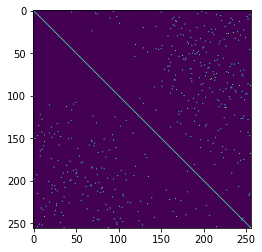

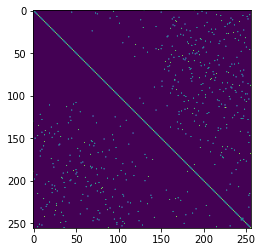

In [173]:
distances = torch.cdist(samples,samples).squeeze()
final_distances = distances.cpu()
_ , nearest_idx = torch.topk(final_distances,3,1,False)
affinity_matrix = torch.eye(256)
ind_new = (torch.arange(0,256)[:, None],nearest_idx)
affinity_matrix[ind_new] = 1
sample_labels = gt_label[sample_idx].unsqueeze(0).unsqueeze(-1).float()
label_similarity = torch.cdist(sample_labels, sample_labels)
label_similarity = (label_similarity == 0).int().squeeze()
affinity_matrix = torch.logical_and(label_similarity,affinity_matrix)

# print(affinity_matrix[nearest_idx[:,1],nearest_idx[:,1]])
# print(affinity_matrix[nearest_idx[:,0]])
# print(affinity_matrix)
# _, three_nearest_idx


In [222]:
def calculate_initial_clustering(points):
    points = torch.from_numpy(points).type(torch.DoubleTensor)
    mins, _ = torch.min(points, axis=0)
    maxs, _ = torch.max(points, axis=0)
    mins = mins.unsqueeze(0)
    maxs = maxs.unsqueeze(0)
    points = (points - mins) / (maxs - mins) - 0.5
    points = points.cuda().unsqueeze(0).float()
    sample_idx = furthest_point_sample(points, 256).long().squeeze()
    samples = points[:, sample_idx, :]
    distances = torch.cdist(points, samples)
    _, nearest_idx = torch.topk(distances, 1, 2, False)
    initial_clusters = nearest_idx.squeeze().cpu()
    return points.squeeze().cpu().numpy(), initial_clusters.numpy(), sample_idx.cpu().numpy()


def calculate_affinity_matrix(points, sample_idx, gt_label):
    points = torch.from_numpy(points).type(torch.DoubleTensor)
    gt_label = torch.from_numpy(gt_label).squeeze()
    sample_idx = torch.from_numpy(sample_idx)
    samples = points[sample_idx, :]
    distances = torch.cdist(samples, samples).squeeze()
    final_distances = distances.cpu()
    _, nearest_idx = torch.topk(final_distances, 3, 1, False)
    affinity_matrix = torch.eye(256)
    ind_new = (torch.arange(0, 256)[:, None], nearest_idx)
    affinity_matrix[ind_new] = 1
    sample_labels = gt_label[sample_idx].unsqueeze(0).unsqueeze(-1).float()
    label_similarity = torch.cdist(sample_labels, sample_labels)
    label_similarity = (label_similarity == 0).int().squeeze()
    affinity_matrix = torch.logical_and(label_similarity, affinity_matrix)
    return affinity_matrix.numpy()

(8000,) (256,)
(256, 256)


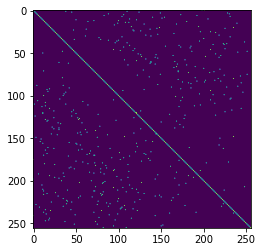

In [223]:
ind = 345
points = data[ind]
gt_label = labels[ind]

new_points, init_clusters, sample_idx = calculate_initial_clustering(points)
affinity_matrix = calculate_affinity_matrix(points, sample_idx, gt_label)
print(init_clusters.shape, sample_idx.shape)
print(affinity_matrix.shape)
plt.imshow(affinity_matrix)

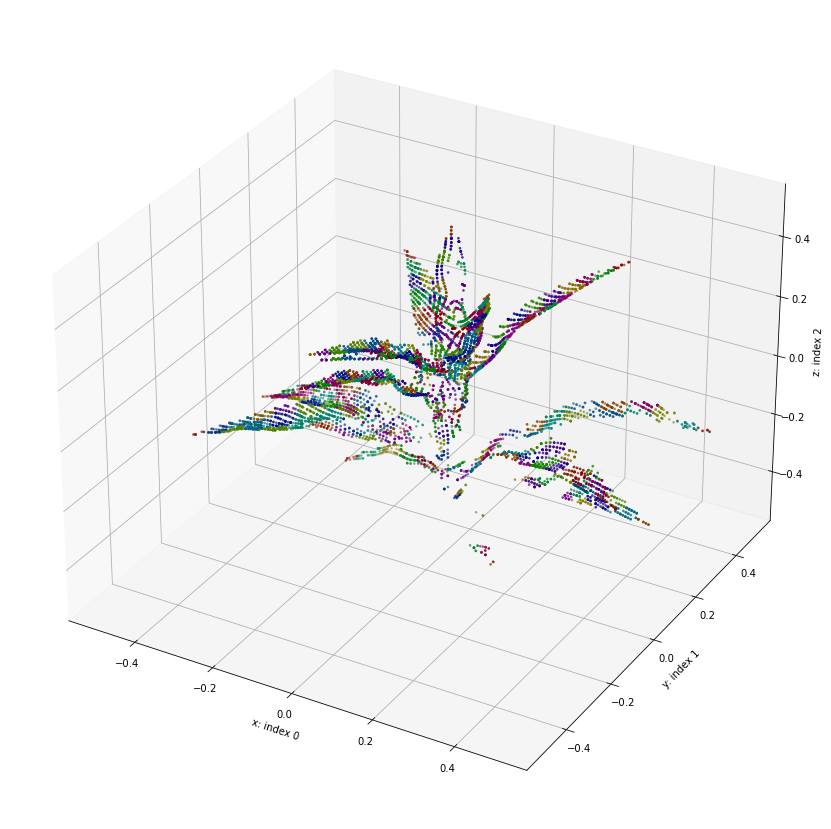

In [224]:
# points = data[ind]
points = new_points
label = labels[ind].squeeze()
label = init_clusters

d_colors = distinct_colors(len(list(set(label))))
colors = np.zeros((label.shape[0],3))
for i, l in enumerate(list(set(label))):
    colors[label == l, :] = d_colors[i]
    
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], s=3, c=colors)
ax.set_xlabel("x: index 0")
ax.set_ylabel("y: index 1")
ax.set_zlabel("z: index 2")
plt.show()

In [229]:
with h5py.File("/space/ariyanzarei/sorghum_segmentation/dataset/synthetic/2022-12-26/h5_tpn/instance_segmentation_train.hdf5") as f:
    print(f.keys())
    data = np.array(f["points"])
    labels = np.array(f["cluster_labels"])

<KeysViewHDF5 ['affinities', 'cluster_labels', 'local_clusters', 'local_context_idx', 'points']>


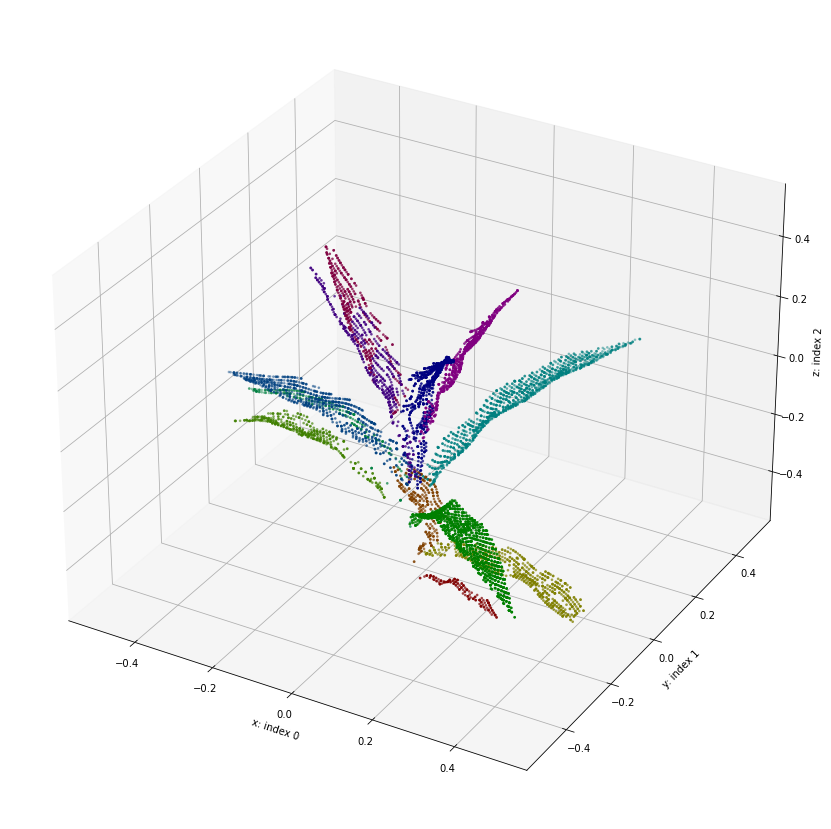

In [230]:
ind = 3
points = data[ind]
label = labels[ind].squeeze()

d_colors = distinct_colors(len(list(set(label))))
colors = np.zeros((label.shape[0],3))
for i, l in enumerate(list(set(label))):
    colors[label == l, :] = d_colors[i]
    
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], s=3, c=colors)
ax.set_xlabel("x: index 0")
ax.set_ylabel("y: index 1")
ax.set_zlabel("z: index 2")
plt.show()